We seek to explore how $3\times3$ correlation matrices behave. 

The space $Cor_3$ of these matrices is an affine subspace of the space of symmetric positive definite matrices $Sym^{+}_3$ where the diagonal entries are set to $1$ and the off-diagonal entries are bounded between $-1$ and $1$. 

The way we will look at the matrices is by using the mapping $Cor_3 \to \mathbb{R}^3$ given by

$$
\begin{bmatrix}
1 & x & y \\
x & 1 & z \\
y & z & 1 
\end{bmatrix} \mapsto 
\begin{pmatrix}
x\\
y\\
z
\end{pmatrix}
$$

These matrices in $\mathbb{R}^3$ lie inside a convex polytope. We will start by a fully correlated matrix (all $1$'s), generated by correlating three identical variables, and we will add Gaussian noise to them in turn and see the path these matrices follow in the polytope. The expected behavior is that they will get closer and closer to zero.

We will also compute the euclidean distance between the subsequent vectors in $\mathbb{R}^3$ and approximate a geodesic distance bewteen the corresponding correlation matrices and then compare the results. 

For further reading in this topic please refer to the following:
* https://gmarti.gitlab.io/math/2019/12/25/riemannian-mean-correlation.html
* https://arxiv.org/abs/2103.04621
* https://hal.archives-ouvertes.fr/hal-00820475/document
* https://www.sciencedirect.com/science/article/pii/S002437951400408X
* http://www.ipb.uni-bonn.de/pdfs/Forstner1999Metric.pdf
* https://www.cis.upenn.edu/~cis6100/cis610-18-sl13.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We will not solve the geodesic equation to get the exact shortest path between two correlation matrices, because that is in general quite difficult to solve and we have two helping factors in this case: one is that we will be perturbing the random variables by a small amount, so we expect the corresponding matrices to be close together, in the euclidean setting and in the manifold, so a sensible path between them is expected to be close to the geodesic. The second one is that the polytope in $\mathbb{R}^3$ is convex, so we can use the linear interpolation between the correlation matrices to stay inside the manifold (hopefully), and ease the computations.

The approximate length of a curve $\gamma$ in the manifold is given by:

$$
L(\gamma) = \int_{0}^{1}\sqrt{g(\gamma'(t),\gamma'(t))}dt
$$

where $g$ is the metric on the space for which we will use $g_{\Sigma}(v,v)=tr(\Sigma^{-1}v\Sigma^{-1}v)$ where $\Sigma \in Sym^{+}$ and $v \in T_{\Sigma}Sym^{+}$.

Given two correlation matrices $C_1$ and $C_2$ we will define $\gamma(t) = (1-t)C_1 + tC_2$. This has the benefit of having a constant derivative $\gamma(t) = C_2 - C_1$. Using a small step size $\Delta t$, we approximate $L$ by:

$$
L(\gamma) \approx \sum_{i=0}^{N}\sqrt{g_{\gamma(t_i)}(C_2 - C_1,C_2 - C_1)} \Delta t
$$

In [10]:
# first define the curve gamma evaluated at some t
def gamma(t,C1,C2):
  return (1-t)*C1 + t*C2

#now define the metric element
def gmetric(Sigma, V):
  sig_inv = np.linalg.inv(Sigma)
  multip = sig_inv*V*sig_inv*V
  return np.trace(multip)

def approx_L(C1,C2,steps=5):
  approx_int = 0
  delta_t = 1/steps
  for i in range(steps):
    metric = gmetric(
        gamma(i*delta_t, C1, C2), C1-C2
    )
    product = np.sqrt(metric)*delta_t
    approx_int = approx_int + product
  return approx_int


In [28]:
vec_size = 20
sigma = 0.1
X = np.random.random(size=vec_size)
Y, Z= X, X
var_vect = [X,Y,Z]

In [29]:
corr_0 = np.corrcoef(var_vect)
corrmats = [
    np.array([corr_0[0,1], corr_0[0,2], corr_0[1,2]])
]
norms_eps = [0]
corr_dist_euclid = [0]
corr_dist_riemm = [0,0]

In [30]:
num_iters = 100
prev_corrmat = corr_0
for i in range(num_iters):
  indx = i%3   # sum to each variable in turn
  eps = np.random.normal(loc=0, scale= sigma, size=vec_size)  # generate perturbation vector
  var_vect[indx] = var_vect[indx] + eps # add perturbation
  corrmat = np.corrcoef(var_vect) # compute correlation matrix
  corrmat_offdiag = np.array([corrmat[0,1], corrmat[0,2], corrmat[1,2]]) # get off-diagonal elements
  corr_dist_euclid.append(
      np.linalg.norm(
          corrmats[i]-corrmat_offdiag # get euclidean distance between the two successive corr matrices
      )
  )
  if i != 0:
    corr_dist_riemm.append(
        approx_L(corrmat,prev_corrmat)
    )
  corrmats.append(corrmat_offdiag) # save the off-diag elements
  norms_eps.append(np.linalg.norm(eps)) # save the norm of the perturbation
  prev_corrmat = corrmat

In [31]:
corrmats_array = np.array(corrmats)

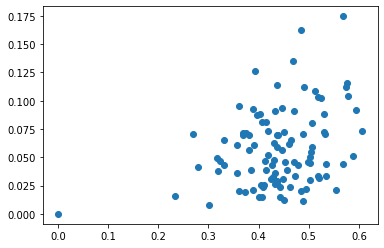

In [32]:
plt.scatter(norms_eps, corr_dist_euclid)

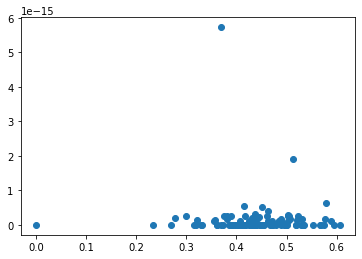

In [33]:
plt.scatter(norms_eps, corr_dist_riemm)

We see the euclidean and the manifold distances don't coincide generally (otherwise we'd see a line at $y=x$. This highlights the importance of the metric selection.

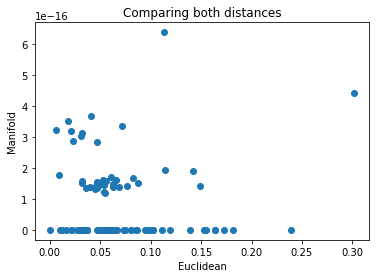

In [46]:
plt.scatter(corr_dist_euclid, corr_dist_riemm)
plt.xlabel("Euclidean")
plt.ylabel("Manifold")
plt.title("Comparing both distances")
plt.show()

In [34]:
xs = corrmats_array[:,0]
ys = corrmats_array[:,1]
zs = corrmats_array[:,2]

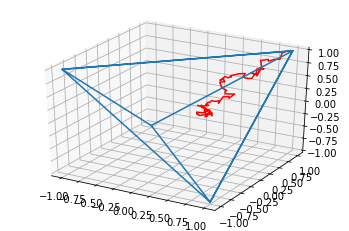

In [73]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.scatter(xs, ys, zs, marker='o')
ax.plot(xs,ys,zs, color='r')
ax.plot([1,1,-1,-1,-1,1,1,-1,1,-1],[1,-1,1,-1,-1,1,-1,-1,1,1],[1,-1,-1,1,1,1,-1,1,1,-1])

In [ ]:
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')

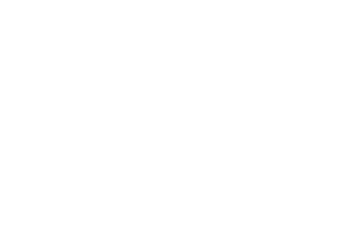

In [64]:
from matplotlib import animation

def init():
    ax.plot(xs,ys,zs, color='r')
    ax.plot([1,1,-1,-1,-1,1,1,-1,1,-1],[1,-1,1,-1,-1,1,-1,-1,1,1],[1,-1,-1,1,1,1,-1,1,1,-1])
    plt.axis('off')
    plt.grid(b=None)
    return fig,

def animate(i):
    ax.view_init(elev=10, azim=i*4)
    return fig,

anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=90, interval=50,
    blit=True)

plt.rcParams['animation.html'] = 'html5'
anim

In [38]:
def gen_paths(sign = [1,1,1], vec_size = 20, sigma= 0.1, num_iters = 100):
  X = np.random.random(size=vec_size)
  Y, Z= X, X
  var_vect = [sign[0]*X,sign[1]*Y,sign[2]*Z]
  corr_0 = np.corrcoef(var_vect)
  corrmats = [
      np.array([corr_0[0,1], corr_0[0,2], corr_0[1,2]])
  ]
  norms_eps = [0]
  corr_dist_euclid = [0]
  corr_dist_riemm = [0,0]
  prev_corrmat = corr_0
  for i in range(num_iters):
    indx = i%3   # sum to each variable in turn
    eps = np.random.normal(loc=0, scale= sigma, size=vec_size)  # generate perturbation vector
    var_vect[indx] = var_vect[indx] + eps # add perturbation
    corrmat = np.corrcoef(var_vect) # compute correlation matrix
    corrmat_offdiag = np.array([corrmat[0,1], corrmat[0,2], corrmat[1,2]]) # get off-diagonal elements
    corr_dist_euclid.append(
        np.linalg.norm(
            corrmats[i]-corrmat_offdiag # get euclidean distance between the two successive corr matrices
        )
    )
    if i != 0:
      corr_dist_riemm.append(
          approx_L(corrmat,prev_corrmat)
      )
    corrmats.append(corrmat_offdiag) # save the off-diag elements
    norms_eps.append(np.linalg.norm(eps)) # save the norm of the perturbation
    prev_corrmat = corrmat

  return np.array(corrmats), norms_eps, corr_dist_euclid, corr_dist_riemm

In [39]:
corrmats, norms_eps, corr_dist_euclid, corr_dist_riemm = gen_paths()

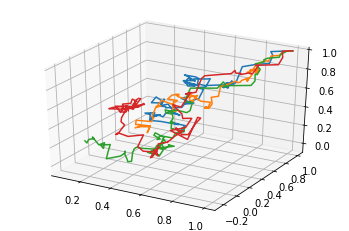

In [65]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.scatter(xs, ys, zs, marker='o')
#ax.plot([1,1,-1,-1,-1,1,1,-1,1,-1],[1,-1,1,-1,-1,1,-1,-1,1,1],[1,-1,-1,1,1,1,-1,1,1,-1])
norms = []
d_euc = []
d_riem = []
run = []
for i in range(4):
  corrmats, norms_eps, corr_dist_euclid, corr_dist_riemm = gen_paths()
  norms.append(norms_eps)
  d_euc.append(corr_dist_euclid)
  d_riem.append(corr_dist_riemm)
  run.append([i]*len(norms_eps))
  ax.plot(corrmats[:,0],corrmats[:,1],corrmats[:,2])

In [69]:
def init():
    ax.plot([1,1,-1,-1,-1,1,1,-1,1,-1],[1,-1,1,-1,-1,1,-1,-1,1,1],[1,-1,-1,1,1,1,-1,1,1,-1])
    norms = []
    d_euc = []
    d_riem = []
    run = []
    for i in range(4):
      corrmats, norms_eps, corr_dist_euclid, corr_dist_riemm = gen_paths()
      norms.append(norms_eps)
      d_euc.append(corr_dist_euclid)
      d_riem.append(corr_dist_riemm)
      run.append([i]*len(norms_eps))
      ax.plot(corrmats[:,0],corrmats[:,1],corrmats[:,2])
    return fig,

def animate(i):
    ax.view_init(elev=10, azim=i*4)
    return fig,

anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=90, interval=50,
    blit=True)

plt.rcParams['animation.html'] = 'html5'
anim

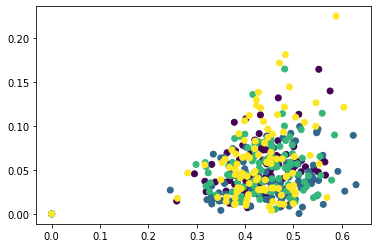

In [72]:
plt.scatter(norms, d_euc, c=run )